In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from itertools import islice
import statsmodels.api as sm
sns.set()
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

In [3]:
def parse_timestamp(el):
    b = datetime.datetime.strptime(el, fmt)
    return b

In [4]:
def create_date_col(df_m):
    date_lst = []
    for index, row in df_m.iterrows():
        day = str(df_m['ride_begin'][index].day)
        month = str(df_m['ride_begin'][index].month)
        year = str(df_m['ride_begin'][index].year)
        date_text = year + '-' + month + '-' + day
        date_lst.append(date_text)
    return date_lst

In [5]:
def trim_latlng(x):
    return round(x,4)

In [6]:
fmt = '%Y-%m-%d %H:%M:%S'

In [7]:
url = "/bigdata/jelicicna/mobility_data_2020/anlysis_data_nextbike_2020-01.csv"
df = pd.read_csv(url, sep=';', low_memory=False)

In [8]:
df.drop('old_index', axis=1, inplace=True)

In [9]:
df['ride_begin'] = df['ride_begin'].map(parse_timestamp)
df['ride_end'] = df['ride_end'].map(parse_timestamp)

In [10]:
df['lat_begin'] = df['lat_begin'].map(trim_latlng)
df['lng_begin'] = df['lng_begin'].map(trim_latlng)
df['lat_end'] = df['lat_end'].map(trim_latlng)
df['lng_end'] = df['lng_end'].map(trim_latlng)

In [11]:
df['date'] = create_date_col(df)

In [12]:
len(df)

53527

In [13]:
df.describe()

,lat_begin,lng_begin,lat_end,lng_end,ride_time,distance,uid_begin,uid_end,standing_before_ride,available_bikes,calculated_distance
count,53527.000000,53527.000000,53527.000000,53527.000000,53527.000000,53527.000000,5.352700e+04,5.352700e+04,53527.000000,53527.000000,53527.000000
mean,50.940968,6.949682,50.940986,6.949582,34.586078,1673.346050,2.701368e+07,2.702925e+07,489.825901,2566.433688,15927.531900
std,0.019347,0.033318,0.019407,0.033370,64.103131,1242.764352,4.322744e+05,3.185038e+05,1179.679434,43.238643,26707.845066
min,50.732200,6.833300,50.733700,6.772900,2.000000,200.000000,3.600450e+05,3.786530e+05,0.000000,2438.000000,1500.000000
25%,50.927300,6.924900,50.927300,6.924800,10.000000,750.000000,2.676969e+07,2.678715e+07,38.000000,2534.000000,6500.000000
50%,50.938900,6.946700,50.938900,6.946600,17.000000,1311.000000,2.702641e+07,2.704066e+07,131.000000,2571.000000,9000.000000
75%,50.953900,6.970400,50.953900,6.970300,29.000000,2279.000000,2.727281e+07,2.728086e+07,489.000000,2604.000000,14000.000000
max,51.028600,7.097400,51.028600,7.101500,699.000000,14587.000000,2.745492e+07,2.745523e+07,33270.000000,2673.000000,291500.000000


/ssd/jelicicna/thesisenv/lib/python3.5/site-packages/seaborn/regression.py:576: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


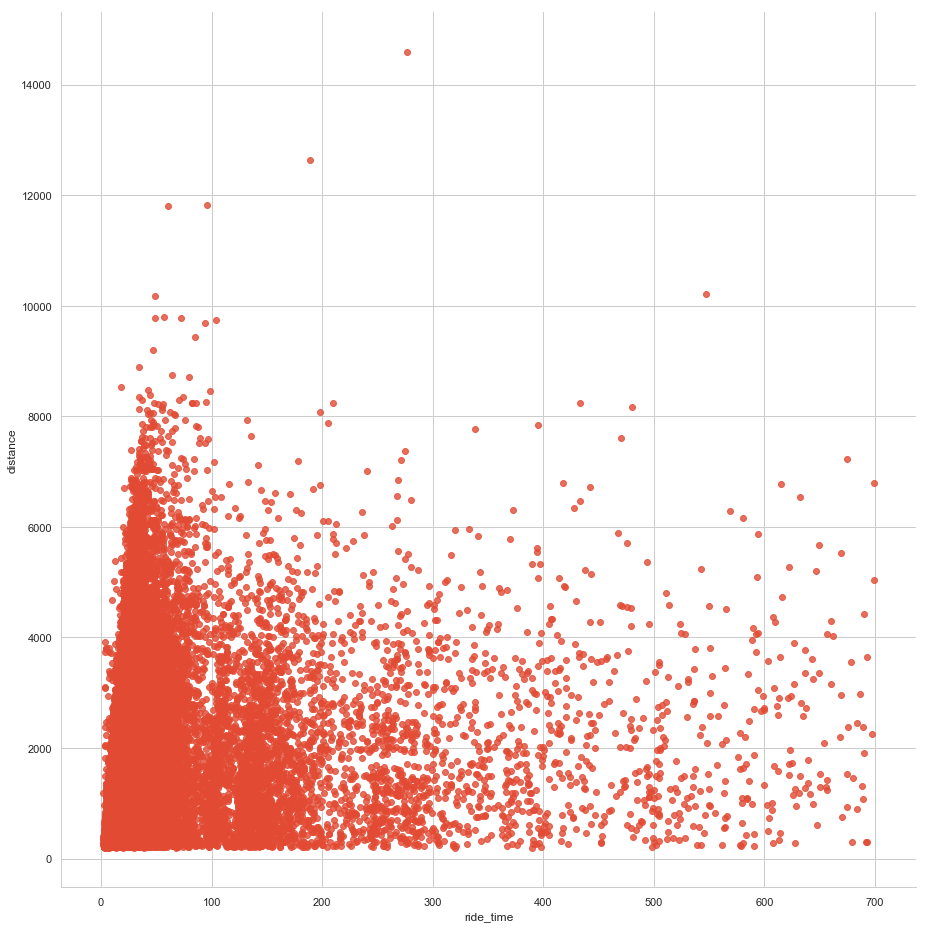

In [14]:
sns.set_style('whitegrid')
sns.lmplot('ride_time','distance',data=df,
           palette='coolwarm',size=13,aspect=1,fit_reg=False)

In [15]:
#adding tracking of original indexes to merge tables with
df.reset_index(inplace=True)
df.rename({'index':'org_index'}, axis=1, inplace=True)

In [16]:
bikes = df[["name"]].drop_duplicates().reset_index(drop=True)
bikes["bike_id"]=bikes.index
bikes = bikes[["bike_id", "name"]]
bikes.head() #df with 2 columns containing bike id and corresponding bike names

,bike_id,name
0,0,BIKE 22739
1,1,BIKE 21116
2,2,BIKE 22126
3,3,BIKE 22915
4,4,BIKE 21579


In [17]:
#adding bike id to df
df = pd.merge(df, bikes, on='name', how='outer')

In [18]:
#checking for a number of unique locations
df.groupby(['lat_begin','lng_begin']).count()

,,org_index,lat_end,lng_end,ride_begin,ride_end,ride_time,distance,uid_begin,uid_end,standing_before_ride,name,available_bikes,calculated_distance,date,bike_id
lat_begin,lng_begin,,,,,,,,,,,,,,,
50.7322,7.0974,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
50.8582,6.9722,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
50.8731,7.0342,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
50.8732,6.9175,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
50.8752,7.0192,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
50.8788,7.0107,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
50.8811,7.0153,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
50.8815,6.9973,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
50.8856,7.0542,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [19]:
#creating a list of unique locations
locations = [] #a list of marked locations
new_col = []
count = 0
first_row_data = df.iloc[0]
loc_str = str([first_row_data['lat_begin'],first_row_data['lng_begin']])
new_col.append(loc_str)
locations.append(loc_str)
for index, row in islice(df.iterrows(), 1, None):
    loc_str = str([row['lat_begin'],row['lng_begin']])
    new_col.append(loc_str)
    if loc_str in locations:
        count += 1
        #print('already placed' + str(count))
    else:
        locations.append(loc_str)

In [20]:
#checking for the expected number of unique locations
len(locations)

41507

In [21]:
#creating a list of unique locations
locations2 = [] #a list of marked locations
new_col = []
count = 0
first_row_data = df.iloc[0]
loc_str = str([first_row_data['lat_end'],first_row_data['lng_end']])
new_col.append(loc_str)
locations2.append(loc_str)
for index, row in islice(df.iterrows(), 1, None):
    loc_str = str([row['lat_end'],row['lng_end']])
    new_col.append(loc_str)
    if loc_str in locations2:
        count += 1
        #print('already placed' + str(count))
    else:
        locations2.append(loc_str)

In [22]:
len(locations2)

41648

In [23]:
locations = list(set(locations + locations2))

In [24]:
type(list(locations))

list

In [25]:
df_locations = pd.DataFrame()
df_locations['latlng'] = locations

In [26]:
df_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47103 entries, 0 to 47102
Data columns (total 1 columns):
latlng    47103 non-null object
dtypes: object(1)
memory usage: 368.1+ KB


In [27]:
lst_lat = []
lst_lng = []
for index, row in df_locations.iterrows():
    string_loc = row['latlng']
    lat = float(string_loc.split('[')[1].split(',')[0])
    lng  = float(string_loc.split(']')[0].split(' ')[1])
    lst_lat.append(lat)
    lst_lng.append(lng)

In [28]:
df_locations['lat'] = lst_lat
df_locations['lng'] = lst_lng

In [29]:
out_of_range = []
for index, row in df_locations.iterrows():
    if (row['lat'] < 50.85) or (row['lat'] > 51.05):
        out_of_range.append(index)
    elif (row['lng'] < 6.80) or (row['lng'] > 7.10):
        out_of_range.append(index)

In [30]:
df_locations.drop(out_of_range, inplace=True)
df_locations.reset_index(drop=True, inplace=True)

In [31]:
len(out_of_range)

4

In [32]:
df_locations.iloc[out_of_range]

,latlng,lat,lng
5191,"[50.9465, 6.92]",50.9465,6.9200
5800,"[50.9119, 6.929]",50.9119,6.9290
35943,"[50.9201, 6.9018]",50.9201,6.9018
45988,"[50.9425, 6.9602]",50.9425,6.9602


In [33]:
from shapely.geometry import Point, Polygon

#saving all locations as geometry points for Shapely library to check if they are inside or ouside of the Polygone for Flexzone
point_tuples = []
for index, row in df_locations.iterrows():
    tpl = Point(row['lng'], row['lat'])
    point_tuples.append(tpl)

# Polygone coordinates taken from the API, there are two of them because the flexzone is separated with the river
cologne_a = [(6.984002,50.900638), (6.983874,50.901882), (6.982758,50.902748), (6.981642,50.903723), (6.979797,50.905482), (6.977608,50.907647), (6.975119,50.910461), (6.973445,50.912491), (6.972372,50.914141), (6.970742,50.916685), (6.969111,50.91958), (6.968166,50.921663), (6.96732,50.923733), (6.966581,50.92538), (6.966931,50.925506), (6.966216,50.927552), (6.965291,50.930026), (6.964573,50.932291), (6.964396,50.932918), (6.964208,50.932914), (6.963839,50.931948), (6.963936,50.931537), (6.96443,50.930021), (6.965079,50.928273), (6.965933,50.925981), (6.965082,50.925824), (6.963446,50.928047), (6.96306,50.929156), (6.962931,50.930616), (6.962888,50.93232), (6.963274,50.933159), (6.963489,50.93443), (6.963317,50.936404), (6.963188,50.937621), (6.962802,50.940434), (6.962716,50.941759), (6.962931,50.943679), (6.963403,50.945436), (6.964132,50.947086), (6.965548,50.949195), (6.967823,50.951817), (6.970742,50.954305), (6.972973,50.9559), (6.974904,50.956846), (6.979282,50.959116), (6.981599,50.960684), (6.982801,50.963171), (6.986663,50.964955), (6.989152,50.966306), (6.988637,50.967766), (6.987951,50.969441), (6.985976,50.970522), (6.980998,50.970955), (6.977651,50.971333), (6.977308,50.971928), (6.974389,50.975819), (6.973016,50.977738), (6.971299,50.979494), (6.968638,50.982628), (6.968724,50.983168), (6.968209,50.983871), (6.967008,50.986086), (6.962695,50.992272), (6.961246,50.994697), (6.960206,50.997175), (6.954562,50.996675), (6.952524,50.996297), (6.950914,50.995595), (6.949262,50.995278), (6.948844,50.9947), (6.947953,50.994366), (6.947266,50.994622), (6.946666,50.995169), (6.946194,50.995446), (6.945249,50.995473), (6.942224,50.996135), (6.938972,50.996998), (6.936465,50.997452), (6.934113,50.997772), (6.931227,50.998164), (6.926165,50.998781), (6.920844,50.999484), (6.920898,51), (6.921,51.000128), (6.921243,51.000201), (6.921524,51.000198), (6.921546,51.000828), (6.920977,51.00081), (6.920038,51.00082), (6.920005,51.000179), (6.920437,51.000155), (6.920601,51.000092), (6.920597,50.999509), (6.91992,50.999574), (6.918612,50.999747), (6.917186,51.000019), (6.914943,51.000199), (6.913583,51.000127), (6.91113,51.000077), (6.908233,51.000048), (6.905749,50.999831), (6.904208,50.99953), (6.902999,50.999125), (6.901763,50.998418), (6.90051,50.997598), (6.898691,50.996562), (6.897318,50.995677), (6.895586,50.994408), (6.894141,50.993395), (6.892537,50.992425), (6.890506,50.991577), (6.888209,50.990771), (6.885485,50.989947), (6.883197,50.989189), (6.881193,50.988533), (6.879071,50.987842), (6.877218,50.986926), (6.876068,50.986008), (6.87508,50.984775), (6.874004,50.983414), (6.873393,50.982311), (6.872714,50.980371), (6.87177,50.977034), (6.870448,50.972239), (6.869503,50.970496), (6.869074,50.969604), (6.868773,50.968577), (6.868172,50.967306), (6.866842,50.965496), (6.866198,50.964063), (6.866198,50.962955), (6.866714,50.961955), (6.867658,50.960036), (6.868559,50.95836), (6.86916,50.956819), (6.869889,50.95471), (6.870447,50.95325), (6.871048,50.952034), (6.871863,50.950871), (6.872936,50.949573), (6.874009,50.948492), (6.874867,50.947573), (6.876241,50.946356), (6.879459,50.943976), (6.881734,50.942056), (6.882635,50.940921), (6.882893,50.939947), (6.883011,50.9386424), (6.8830431,50.937757), (6.8751522,50.9378651), (6.867712,50.9379321), (6.8676958,50.9372088), (6.8679372,50.9322664), (6.8703615,50.9322126), (6.8734728,50.9321044), (6.8761871,50.9319757), (6.8786387,50.9318504), (6.8808944,50.9322881), (6.8831167,50.9329261), (6.8857467,50.9338481), (6.8862726,50.9340007), (6.886498,50.93345), (6.88697,50.932753), (6.888686,50.929085), (6.889137,50.927768), (6.88962,50.927326), (6.889931,50.926613), (6.890102,50.925017), (6.890575,50.923259), (6.891047,50.920851), (6.891347,50.919309), (6.892034,50.917794), (6.892678,50.916955), (6.893364,50.916333), (6.894823,50.915386), (6.896626,50.91452), (6.8989,50.91333), (6.904479,50.910705), (6.906239,50.909839), (6.911432,50.907376), (6.912505,50.906754), (6.9120437,50.9064531), (6.9094687,50.905117), (6.9084333,50.9055501), (6.9063479,50.9068), (6.9061206,50.9069379), (6.9059147,50.9070216), (6.905959,50.9070673), (6.9054554,50.9073304), (6.9049355,50.9069545), (6.9053192,50.9067057), (6.9055009,50.9066874), (6.905849,50.9069263), (6.9061571,50.906743), (6.9064599,50.9065461), (6.9077551,50.9057505), (6.908508,50.9053181), (6.9095828,50.9049568), (6.9109634,50.9056222), (6.9117444,50.9060076), (6.9123859,50.9064166), (6.9126626,50.9066667), (6.913964,50.905726), (6.91538,50.904454), (6.916496,50.90356), (6.919371,50.901233), (6.924221,50.897714), (6.925894,50.896713), (6.927396,50.896226), (6.930915,50.895684), (6.938683,50.895089), (6.941559,50.89471), (6.947138,50.894385), (6.9513,50.894222), (6.959025,50.8936), (6.965034,50.893086), (6.96748,50.892815), (6.968896,50.892869), (6.97057,50.89295), (6.972501,50.89314), (6.973617,50.893492), (6.974389,50.893735), (6.976106,50.895089), (6.976792,50.895603), (6.978295,50.896632), (6.979797,50.897768), (6.981556,50.899014), (6.982758,50.899636), (6.983852,50.900103), (6.984732,50.900228), (6.985333,50.900243), (6.985547,50.900448), (6.985494,50.900786), (6.984925,50.901152), (6.984002,50.900638)]
cologne_b = [(6.98255,50.920101), (6.981397,50.919419), (6.980166,50.918978), (6.978034,50.91851), (6.979071,50.917289), (6.982834,50.913202), (6.986276,50.910102), (6.987993,50.909203), (6.988759,50.908592), (6.989061,50.908719), (6.991253,50.907411), (6.992294,50.906576), (6.992755,50.906294), (6.996186,50.905047), (6.997399,50.905939), (6.997615,50.906619), (6.998375,50.907707), (6.997379,50.908094), (6.997518,50.908682), (6.998377,50.908601), (7.000297,50.910116), (6.999718,50.910197), (7.000969,50.911221), (7.001542,50.911165), (7.003187,50.91152), (7.006531,50.912349), (7.006917,50.912545), (7.008526,50.913248), (7.009406,50.913627), (7.010672,50.913952), (7.010994,50.914141), (7.011146,50.914904), (7.011068,50.915316), (7.010529,50.915519), (7.001064,50.916482), (7.001376,50.917236), (6.997964,50.917875), (6.996899,50.918154), (6.998498,50.919135), (6.998946,50.919825), (6.999586,50.919933), (7.000778,50.920555), (7.004622,50.922178), (7.008786,50.924265), (7.011213,50.926271), (7.014742,50.934006), (7.011915,50.936833), (7.009088,50.938821), (7.013143,50.939499), (7.014043,50.939692), (7.018397,50.940006), (7.023095,50.940076), (7.03219,50.939864), (7.0149,50.952497), (7.014276,50.952963), (7.013976,50.953433), (7.014008,50.955158), (7.014046,50.955602), (7.01256,50.956633), (7.012164,50.956954), (7.013626,50.959126), (7.01308,50.959379), (7.013948,50.960746), (7.013774,50.961413), (7.013612,50.962073), (7.014384,50.963097), (7.017566,50.963742), (7.017506,50.963909), (7.017538,50.964056), (7.017694,50.964271), (7.017946,50.964632), (7.018534,50.965254), (7.018888,50.965622), (7.019244,50.965965), (7.01941,50.96617), (7.019516,50.966351), (7.019598,50.966609), (7.019786,50.967225), (7.0198,50.967413), (7.0198,50.967602), (7.019786,50.967795), (7.019746,50.967987), (7.019618,50.968442), (7.019078,50.969612), (7.01881,50.970094), (7.018316,50.97059), (7.01595,50.972316), (7.015554,50.971816), (7.014904,50.97162), (7.01413,50.971603), (7.013292,50.970676), (7.01307,50.970532), (7.01268,50.970604), (7.012222,50.970487), (7.01148,50.970645), (7.01404,50.973289), (7.013332,50.973995), (7.014524,50.97397), (7.01507,50.974242), (7.014986,50.97487), (7.014534,50.975208), (7.013596,50.974765), (7.012926,50.974153), (7.01277,50.974162), (7.012652,50.974032), (7.012674,50.973881), (7.01229,50.973524), (7.010782,50.974002), (7.00918,50.974697), (7.007426,50.975466), (7.006776,50.975734), (7.006662,50.975988), (7.00642,50.976169), (7.006176,50.976241), (7.005422,50.975581), (7.004562,50.975555), (7.005224,50.974361), (7.005492,50.973951), (7.005706,50.973636), (7.005754,50.973243), (7.006072,50.972604), (7.006188,50.972184), (7.00625,50.971763), (7.006276,50.971254), (7.006292,50.97101), (7.00632,50.970948), (7.00633,50.970878), (7.006368,50.970808), (7.006664,50.970698), (7.006718,50.969941), (7.006722,50.969683), (7.00662,50.969267), (7.006108,50.96894), (7.00553,50.968612), (7.005256,50.968443), (7.00492,50.968294), (7.003902,50.967908), (7.002484,50.967378), (7.00219,50.9673), (7.00077,50.966808), (7.000606,50.966681), (7.000558,50.96635), (7.000526,50.965999), (7.000458,50.965678), (7.00025,50.965192), (7.00009,50.964906), (6.99991,50.964677), (6.999486,50.964326), (6.999254,50.964104), (6.99911,50.963953), (6.998896,50.963696), (6.998586,50.963348), (6.998054,50.9628), (6.9978,50.962542), (6.997584,50.962284), (6.997204,50.961752), (6.99704,50.96144), (6.996868,50.961062), (6.996456,50.960308), (6.996124,50.959714), (6.995394,50.958861), (6.994702,50.958003), (6.994096,50.957303), (6.992186,50.955153), (6.991618,50.955282), (6.99129,50.955308), (6.990896,50.955285), (6.990634,50.955229), (6.990214,50.955083), (6.989688,50.954922), (6.988774,50.954683), (6.98835,50.954556), (6.988082,50.954434), (6.987886,50.954302), (6.98667,50.953354), (6.985532,50.952434), (6.983158,50.950544), (6.982882,50.950408), (6.9819709,50.9502391), (6.9800432,50.9515175), (6.9798617,50.95139), (6.980499,50.9508952), (6.9810602,50.9504107), (6.9813511,50.9498609), (6.981086,50.949729), (6.979864,50.94934), (6.979164,50.949074), (6.978786,50.948889), (6.978308,50.948654), (6.977884,50.948411), (6.977472,50.948146), (6.976814,50.94752), (6.9750708,50.9459587), (6.9747491,50.9460805), (6.9745752,50.9462362), (6.9745414,50.9463094), (6.9746613,50.946454), (6.9747181,50.9465429), (6.9747613,50.9466752), (6.9747268,50.9467686), (6.9745383,50.9469104), (6.9738555,50.9467963), (6.9739157,50.9466821), (6.9741061,50.9467015), (6.9741409,50.9464117), (6.9739556,50.9463998), (6.9738943,50.946071), (6.9746964,50.9458592), (6.9748789,50.9457994), (6.9748335,50.9457305), (6.974706,50.9455429), (6.9745381,50.945352), (6.9743856,50.9451979), (6.9734963,50.9455298), (6.9731465,50.9453137), (6.9730566,50.9449487), (6.9717563,50.9450462), (6.9713301,50.9450799), (6.9711043,50.9450829), (6.9708812,50.9450639), (6.970691,50.9450243), (6.9705551,50.9449874), (6.9704024,50.9449425), (6.9703193,50.9449148), (6.9702146,50.9448774), (6.9701382,50.9448399), (6.9700201,50.9447927), (6.9698631,50.9446677), (6.969792,50.944558), (6.969716,50.944424), (6.969694,50.944291), (6.969688,50.944097), (6.969324,50.941982), (6.969214,50.941084), (6.969008,50.940883), (6.968596,50.940878), (6.968366,50.940985), (6.968322,50.940432), (6.968334,50.939892), (6.968364,50.938224), (6.968378,50.937456), (6.968942,50.935793), (6.969548,50.934373), (6.970674,50.932301), (6.970874,50.932345), (6.971386,50.931428), (6.972048,50.930566), (6.972218,50.930343), (6.97244,50.93012), (6.973098,50.929447), (6.97392,50.928823), (6.975006,50.928166), (6.97585,50.927514), (6.975842,50.92737), (6.977074,50.926042), (6.97907,50.924022), (6.979526,50.923583), (6.97992,50.923019), (6.981056,50.921839), (6.98214,50.920598), (6.98255,50.920101)]

poly_a = Polygon(cologne_a)
poly_b = Polygon(cologne_b)

df_locations['points'] = point_tuples

out_of_flexzone = []
for index, row in df_locations.iterrows():
    point = row['points']
    if (point.within(poly_a) == False) and (point.within(poly_b) == False):
        out_of_flexzone.append(index)

In [34]:
print(len(df_locations))

47099


In [35]:
print(len(out_of_flexzone))

1058


In [36]:
df_locations.drop(out_of_flexzone, inplace=True)
df_locations.reset_index(drop=True, inplace=True)

In [37]:
df_locations.head()

,latlng,lat,lng,points
0,"[50.941, 6.977]",50.9410,6.9770,POINT (6.977 50.941)
1,"[50.9201, 6.9859]",50.9201,6.9859,POINT (6.9859 50.9201)
2,"[50.9748, 6.9734]",50.9748,6.9734,POINT (6.9734 50.9748)
3,"[50.9442, 7.0028]",50.9442,7.0028,POINT (7.0028 50.9442)
4,"[50.936, 6.9543]",50.9360,6.9543,POINT (6.9543 50.936)


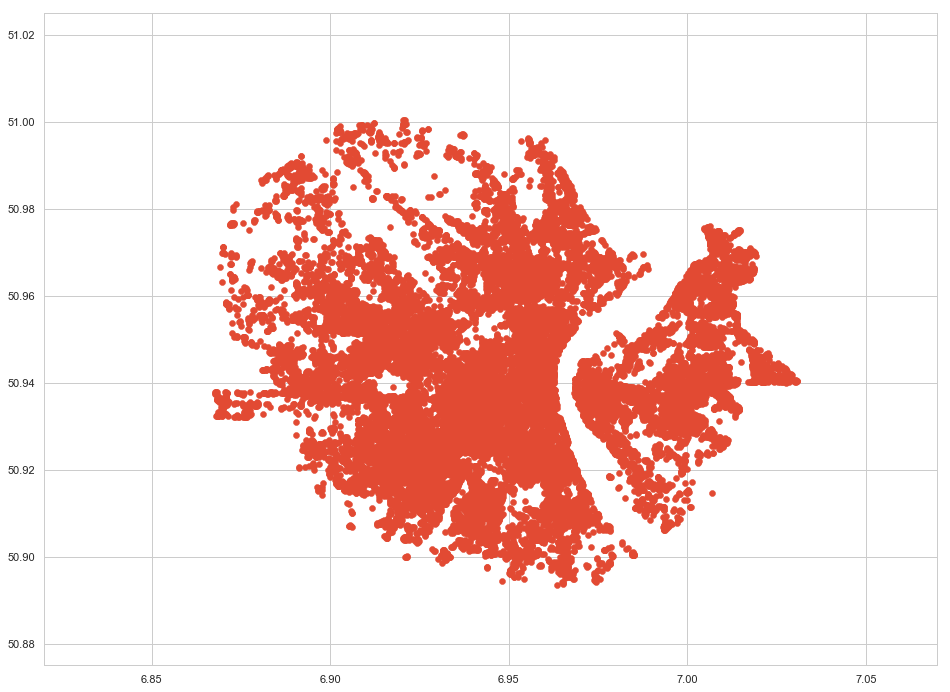

In [38]:
plt.scatter(df_locations['lng'], df_locations['lat'])
plt.xlim(6.82,7.07)
plt.ylim(50.875,51.025)
plt.show()

In [39]:
len(df_locations)

46041

In [40]:
df_locations.reset_index(inplace=True)
df_locations.rename({'index':'loc_id'}, axis=1, inplace=True)

In [41]:
df_locations.to_csv('/bigdata/jelicicna/clustering_datasets/locations_for_clustering_2020-01.csv', sep=';', index=False)